In [66]:
#import libraries (lots of them)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import TransformerMixin
from sklearn.metrics import plot_confusion_matrix

DenseTransformer will help us convert a sparse matrix into a dense matrix and make some of our pipelines work.

In [2]:
# Taken from Noah C.'s Week 5 Lab Review
# originally adaped from:
# https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [67]:
# Load in data
df = pd.read_csv('../data/raw.csv')
X = df['post']
y = df['is_conspiracy']

Models we will try:
1. LogisticRegression
2. GaussianNaiveBayes
3. MultinomialNaiveBayes

The class 'GridSearchContainer' will allow us to remember grid-searched models and help with some code reusability.

In [69]:
# Code adapted from Patrick Wales-Dinan's demonstration on saving GridSearches

class GridSearchContainer:
    def __init__(self, X, y):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y,
                                                                                random_state=42,
                                                                                stratify = y)
        self.model_params = {}
        self.best_models = []
        self.model_df = pd.DataFrame
        self.count = 0
        
    def search(self, estimator, params, mod_name='model', evaluator='accuracy'):
        
            gs = GridSearchCV(estimator,
                  param_grid = params,
                  cv = 5,
                  scoring = evaluator)
    
            gs.fit(self.X_train, self.y_train)

            print(f"Train {evaluator}: {gs.score(self.X_train, self.y_train)}")
            print(f"Test {evaluator}: {gs.score(self.X_test, self.y_test)}")

            gs.best_params_[evaluator] = gs.best_score_
                
            self.model_params[f'{mod_name}_{self.count}'] = gs.best_params_

            self.model_df = pd.DataFrame.from_dict(self.model_params, orient='index')
            self.model_df.sort_values(by=evaluator, ascending=False, inplace=True)

            self.best_models.append((gs.best_estimator_, gs.best_score_))
            
            self.count+=1

In [68]:
#Instantiate first GridSearchContainer
gsc = GridSearchContainer(X, y)

Let's make a bunch of pipelines! The TfidfTransformer will allow us to swap between CountVectorization and TfidfVectorization in the same pipeline.

In [7]:
pipe_lr = Pipeline([('cv', CountVectorizer()),
                    ('tf', TfidfTransformer()),
                    ('lr', LogisticRegression())
                   ])

pipe_gnb = Pipeline([('cv', CountVectorizer()),
                     ('tf', TfidfTransformer()),
                     ("_", DenseTransformer()),
                     ('gnb', GaussianNB())
                   ])

pipe_mnb = Pipeline([('cv', CountVectorizer()),
                     ('mnb', MultinomialNB())
                   ])

Let's start with an attempt to make our best Logistic Regression. It appears that 0.86 was our highest accuracy score for a model with default hyperparameters and tfidf turned on.

In [8]:
params_lr = {
    'cv__lowercase': [True, False],
    'cv__stop_words': [None, 'english'],
    'cv__max_features': [None, 5000, 7000],
    'cv__ngram_range': [(1,1),(1,2)],
    'cv__min_df': [1,3,5,7],
    'tf__use_idf': [True, False]
}

gsc.search(pipe_lr, params_lr, 'logreg')
gsc.model_df.head()

Train accuracy: 0.9525089605734767
Test accuracy: 0.8588709677419355


,cv__lowercase,cv__max_features,cv__min_df,cv__ngram_range,cv__stop_words,tf__use_idf,accuracy
logreg_0,True,None,1,"(1, 1)",None,True,0.868288


Next we'll look at Gaussian Naive Bayes. The best GNB performs 4% worse than the best Logistic Regression. The model also has very high variance (78% accuracy on on testing data).

In [9]:
params_gnb = {
    'cv__lowercase': [True, False],
    'cv__stop_words': [None, 'english'],
    'cv__max_features': [None, 5000, 7000],
    'cv__ngram_range': [(1,1),(1,2)],
    'cv__min_df': [1,3,5,7],
    'tf__use_idf': [True]
}

gsc.search(pipe_gnb, params_gnb, 'gnb')
gsc.model_df.head()

Train accuracy: 0.9126344086021505
Test accuracy: 0.7849462365591398


,cv__lowercase,cv__max_features,cv__min_df,cv__ngram_range,cv__stop_words,tf__use_idf,accuracy
logreg_0,True,None,1,"(1, 1)",None,True,0.868288
gnb_1,True,None,5,"(1, 1)",None,True,0.821669


Finally we'll look at Multinomial Naive Bayes. This model had the best accuracy and was the least overfit.  Very promising.

In [10]:
params_mnb = {
    'cv__lowercase': [True, False],
    'cv__stop_words': [None, 'english'],
    'cv__max_features': [None, 5000, 7000],
    'cv__ngram_range': [(1,1),(1,2)],
    'cv__min_df': [1,3,5,7],
    'mnb__alpha': [0.5,1,2]
}

gsc.search(pipe_mnb, params_mnb, 'mnb')
gsc.model_df.head()

Train accuracy: 0.9628136200716846
Test accuracy: 0.8736559139784946


,cv__lowercase,cv__max_features,cv__min_df,cv__ngram_range,cv__stop_words,tf__use_idf,accuracy,mnb__alpha
mnb_2,True,None,1,"(1, 1)",None,NaN,0.879927,1.0
logreg_0,True,None,1,"(1, 1)",None,True,0.868288,NaN
gnb_1,True,None,5,"(1, 1)",None,True,0.821669,NaN


Ok now let's evaluate these models on their recall (sensitivity).  The ranking comes in the same order except that MNB has by far the best sensitivity.  We will take MNB and Logistic Regression into the next round of hyperparameter tuning.

In [11]:
gsc.search(pipe_lr, params_lr, 'lr_sn', 'recall')
print()
gsc.search(pipe_gnb, params_gnb, 'gnb_sn', 'recall')
print()
gsc.search(pipe_mnb, params_mnb, 'mnb_sn', 'recall')
gsc.model_df.head(6)

Train recall: 0.990409764603313
Test recall: 0.8638743455497382

Train recall: 0.974716652136007
Test recall: 0.8219895287958116

Train recall: 0.987794245858762
Test recall: 0.8743455497382199


,cv__lowercase,cv__max_features,cv__min_df,cv__ngram_range,cv__stop_words,tf__use_idf,accuracy,mnb__alpha,recall
mnb_sn_5,True,None,1,"(1, 2)",None,NaN,NaN,2.0,0.924177
lr_sn_3,False,None,1,"(1, 2)",english,True,NaN,NaN,0.877968
gnb_sn_4,True,None,3,"(1, 2)",english,True,NaN,NaN,0.853533
logreg_0,True,None,1,"(1, 1)",None,True,0.868288,NaN,NaN
gnb_1,True,None,5,"(1, 1)",None,True,0.821669,NaN,NaN
mnb_2,True,None,1,"(1, 1)",None,NaN,0.879927,1.0,NaN


And then there were two: Multinomial Naive Bayes and Logistic Regression.  Let's instantiate a fresh GridSearchContainer and start looking for ideal parameters that balance good accuracy and precision.

In [25]:
best_log_regs = GridSearchContainer(X, y)

We are trying to identify where tradeoffs between accuracy and recall exist in the parameters.  To do this we will score the recall of the model with the best accuracy and score the accuracy of the model with the best recall. Let's start with Logistic Regression.

In [26]:
params_lr = {
    'cv__lowercase': [True, False],
    'cv__stop_words': [None, 'english'],
    'cv__max_features': [None],
    'cv__ngram_range': [(1,1),(1,2),(1,3)],
    'cv__min_df': [1],
    'tf__use_idf': [True]
}

best_log_regs.search(pipe_lr, params_lr, "best_acc")
best_log_regs.search(pipe_lr, params_lr, "best_rec",evaluator='recall')
best_log_regs.model_df.head()

Train accuracy: 0.9525089605734767
Test accuracy: 0.8588709677419355
Train recall: 0.994768962510898
Test recall: 0.8664921465968587


,cv__lowercase,cv__max_features,cv__min_df,cv__ngram_range,cv__stop_words,tf__use_idf,accuracy,recall
best_rec_1,False,None,1,"(1, 3)",english,True,NaN,0.878838
best_acc_0,True,None,1,"(1, 1)",None,True,0.868288,NaN


It appears that increasing the n-gram range of the Count Vectorizer increases recall marginally and decreases accuracy marginally.  The use of lowercase and stopwords also have an effect, but no score is jumping above the MNB, so we will discard Logistic Regression and look to tune MNB as best we can.

In [27]:
params_best_accuracy = {
    'cv__lowercase': [True],
    'cv__stop_words': [None],
    'cv__max_features': [None],
    'cv__ngram_range': [(1,1)],
    'cv__min_df': [1],
    'tf__use_idf': [True]
}

params_best_recall = {
    'cv__lowercase': [False],
    'cv__stop_words': ['english'],
    'cv__max_features': [None],
    'cv__ngram_range': [(1,3)],
    'cv__min_df': [1],
    'tf__use_idf': [True]
}

best_log_regs.search(pipe_lr, params_best_accuracy, "best_acc_recall", evaluator='recall')

Train recall: 0.951176983435048
Test recall: 0.8324607329842932


In [28]:
best_log_regs.search(pipe_lr, params_best_recall, "best_rec_accuracy", evaluator='accuracy')

Train accuracy: 0.9946236559139785
Test accuracy: 0.8548387096774194


In [29]:
best_log_regs.model_df.head()

,cv__lowercase,cv__max_features,cv__min_df,cv__ngram_range,cv__stop_words,tf__use_idf,accuracy,recall
best_acc_0,True,None,1,"(1, 1)",None,True,0.868288,NaN
best_rec_accuracy_3,False,None,1,"(1, 3)",english,True,0.855735,NaN
best_rec_1,False,None,1,"(1, 3)",english,True,NaN,0.878838
best_acc_recall_2,True,None,1,"(1, 1)",None,True,NaN,0.848346


In [41]:
best_mnbs = GridSearchContainer(X, y)

In [42]:
params_mnb = {
    'cv__lowercase': [True, False],
    'cv__stop_words': [None, 'english'],
    'cv__max_features': [None],
    'cv__ngram_range': [(1,1),(1,2),(1,3)],
    'cv__min_df': [1],
    'mnb__alpha': [1,2,3]
}

best_mnbs.search(pipe_mnb, params_mnb, "best_acc")
best_mnbs.search(pipe_mnb, params_mnb, "best_rec",evaluator='recall')
best_mnbs.model_df.head()

Train accuracy: 0.9628136200716846
Test accuracy: 0.8736559139784946
Train recall: 0.99128160418483
Test recall: 0.8900523560209425


,cv__lowercase,cv__max_features,cv__min_df,cv__ngram_range,cv__stop_words,mnb__alpha,accuracy,recall
best_rec_1,True,None,1,"(1, 3)",None,3,NaN,0.933773
best_acc_0,True,None,1,"(1, 1)",None,1,0.879927,NaN


Similarly to the Logistic Regression, ngram_range affects accuracy and recall inversely. However, we have a unique hyperparameter tha affects accuracy and recall inversely: the smoothing error **alpha**. We are in the home stretch of determining our model.  The rest of the process will be a repetive re-running of the cell below until we get a combination of hyperparameters that deliver a satisfying tradeoff of accuracy and recall.

In [46]:
params_best_acc_mnb = {
    'cv__lowercase': [True],
    'cv__stop_words': [None],
    'cv__max_features': [None],
    'cv__ngram_range': [(1,1)],
    'cv__min_df': [1],
    'mnb__alpha': [1]
}

params_best_rec_mnb = {
    'cv__lowercase': [True],
    'cv__stop_words': [None],
    'cv__max_features': [None],
    'cv__ngram_range': [(1,2)],
    'cv__min_df': [1],
    'mnb__alpha': [2]
}

best_mnbs.search(pipe_mnb, params_best_acc_mnb, "best_acc_recall", evaluator='recall')
best_mnbs.search(pipe_mnb, params_best_rec_mnb, "best_rec_accuracy", evaluator='accuracy')
best_mnbs.model_df.head(10)

Train recall: 0.96512641673932
Test recall: 0.8691099476439791
Train accuracy: 0.985663082437276
Test accuracy: 0.853494623655914


,cv__lowercase,cv__max_features,cv__min_df,cv__ngram_range,cv__stop_words,mnb__alpha,accuracy,recall
best_acc_0,True,None,1,"(1, 1)",None,1,0.879927,NaN
best_rec_accuracy_3,True,None,1,"(1, 2)",None,2,0.871416,NaN
best_rec_accuracy_7,True,None,1,"(1, 2)",None,2,0.871416,NaN
best_rec_accuracy_9,True,None,1,"(1, 2)",None,2,0.871416,NaN
best_rec_1,True,None,1,"(1, 3)",None,3,NaN,0.933773
best_acc_recall_2,True,None,1,"(1, 1)",None,1,NaN,0.907602
best_acc_recall_4,True,None,1,"(1, 1)",None,1,NaN,0.907602
best_rec_accuracy_5,True,None,1,"(1, 2)",None,2,NaN,0.924177
best_acc_recall_6,True,None,1,"(1, 1)",None,1,NaN,0.907602
best_acc_recall_8,True,None,1,"(1, 1)",None,1,NaN,0.907602


Our final model has an accuracy of a 87% and a recall of 92%. The Count Vectorizer uses monograms and bigrams and undergoes tfidf transformation.  The Multinomial Naive Bayes has an alpha value of 2.

In [47]:
final_model_params = {
    'cv__lowercase': [True],
    'cv__stop_words': [None],
    'cv__max_features': [None],
    'cv__ngram_range': [(1,2)],
    'cv__min_df': [1],
    'mnb__alpha': [2]
}

mnb_final = GridSearchContainer(X, y)

mnb_final.search(pipe_mnb, final_model_params, "mnb_recall", evaluator='recall')
mnb_final.search(pipe_mnb, final_model_params, "best_accuracy", evaluator='accuracy')
mnb_final.model_df.head()

Train recall: 0.987794245858762
Test recall: 0.8743455497382199
Train accuracy: 0.985663082437276
Test accuracy: 0.853494623655914


,cv__lowercase,cv__max_features,cv__min_df,cv__ngram_range,cv__stop_words,mnb__alpha,recall,accuracy
best_accuracy_1,True,None,1,"(1, 2)",None,2,NaN,0.871416
mnb_recall_0,True,None,1,"(1, 2)",None,2,0.924177,NaN


In [56]:
mod = mnb_final.best_models
final_mod = mod[1][0]

Lastly, let's save the confusion matrix of the final model, so we can observe the false negative count.  48 is a little higher than we might want but that is ok because our model has great accuracy.

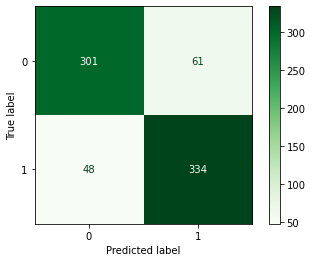

In [65]:
plot_confusion_matrix(final_mod, mnb_final.X_test, mnb_final.y_test, cmap='Greens', values_format='d');
plt.savefig("../images/confusion_matrix.png")